In [63]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [5]:
# build the dataset
block_size = 3

def build_dataset(words):
    
    # length of context
    X, Y = [], []

    for w in words:

        # print(w)
        context = [0] * block_size

        for ch in w + '.':

            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# dataset
# training split, dev/validation split, test split
# 80% (train parameters), 10% (tune hyperparameters), 10% (evaluate model)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [61]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [52]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
            
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
                
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [53]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)

# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

46497


In [59]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

#     if i >= 1000:
#         break # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 2.6813
  10000/ 200000: 2.1170
  20000/ 200000: 2.2530
  30000/ 200000: 1.8894
  40000/ 200000: 2.2213
  50000/ 200000: 1.9751
  60000/ 200000: 1.7499
  70000/ 200000: 1.9849
  80000/ 200000: 2.1912
  90000/ 200000: 1.9013
 100000/ 200000: 1.7619
 110000/ 200000: 1.9003
 120000/ 200000: 1.7965
 130000/ 200000: 1.8668
 140000/ 200000: 2.0406
 150000/ 200000: 1.9838
 160000/ 200000: 2.0449
 170000/ 200000: 2.0218
 180000/ 200000: 1.8208
 190000/ 200000: 1.7402


In [56]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
#         hy, hx = torch.histogram(t, density=True)
#         plt.plot(hx[:-1].detach(), hy.detach())
#         legends.append(f'layer {i} ({layer.__class__.__name__}')
# plt.legend(legends);
# plt.title('activation distribution')

layer 1 (      Tanh): mean -0.04, std 0.64, saturated: 5.19%
layer 3 (      Tanh): mean -0.01, std 0.54, saturated: 0.41%
layer 5 (      Tanh): mean +0.01, std 0.53, saturated: 0.47%
layer 7 (      Tanh): mean -0.02, std 0.53, saturated: 0.28%
layer 9 (      Tanh): mean +0.01, std 0.54, saturated: 0.25%


<Figure size 1440x288 with 0 Axes>

In [57]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
#         hy, hx = torch.histogram(t, density=True)
#         plt.plot(hx[:-1].detach(), hy.detach())
#         legends.append(f'layer {i} ({layer.__class__.__name__}')
# plt.legend(legends);
# plt.title('gradient distribution')

layer 1 (      Tanh): mean +0.000033, std 2.641852e-03
layer 3 (      Tanh): mean +0.000043, std 2.440831e-03
layer 5 (      Tanh): mean -0.000004, std 2.338152e-03
layer 7 (      Tanh): mean +0.000006, std 2.283551e-03
layer 9 (      Tanh): mean +0.000040, std 2.059027e-03


<Figure size 1440x288 with 0 Axes>

In [58]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
#         hy, hx = torch.histogram(t, density=True)
#         plt.plot(hx[:-1].detach(), hy.detach())
#         legends.append(f'{i} {tuple(p.shape)}')
# plt.legend(legends)
# plt.title('weights gradient distribution');

weight   (27, 10) | mean +0.000348 | std 8.758370e-03 | grad:data ratio 8.702224e-03
weight  (30, 100) | mean +0.000151 | std 1.007395e-02 | grad:data ratio 5.258169e-02
weight (100, 100) | mean -0.000087 | std 6.662836e-03 | grad:data ratio 6.450022e-02
weight (100, 100) | mean +0.000021 | std 5.148380e-03 | grad:data ratio 4.974074e-02
weight (100, 100) | mean +0.000015 | std 4.545034e-03 | grad:data ratio 4.419325e-02
weight (100, 100) | mean -0.000044 | std 3.829133e-03 | grad:data ratio 3.732290e-02
weight  (100, 27) | mean +0.000000 | std 1.436651e-02 | grad:data ratio 2.251752e-01


<Figure size 1440x288 with 0 Axes>

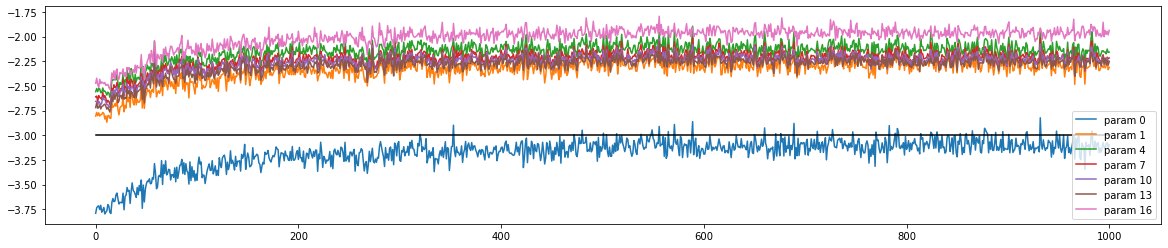

In [40]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [41]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 2.4005014896392822
val 2.3982436656951904


In [60]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

jamelius.
maellia.
makyan.
rayla.
zamil.
avar.
bri.
krindy.
safircadil.
que.
daiaish.
parely.
leighton.
latayla.
zaleylani.
raelyn.
beth.
leb.
kyleigy.
barro.
